In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
sns.set_style('darkgrid')

tf.logging.set_verbosity(tf.logging.ERROR)

pd.set_option('display.max_row', 10)
pd.set_option('display.float_format', '{:.1f}'.format)

In [11]:
def preprocess(df):
    processed_features = df[df.columns[df.columns != 'median_house_value']]
    processed_features['rooms_per_person'] = processed_features['total_bedrooms']/processed_features['population']
    return processed_features, df[['median_house_value']]/1000

In [12]:
def my_input_fn(features, targets = None, batch_size = 1, num_epochs = None, shuffle = True):
    if targets is None:
        targets = np.zeros(len(features))
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [13]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [14]:
def train_model(my_optimizer, steps, batch_size, hidden_units,
                ts, tt, vs, vt, periods = 10):
    '''
    my_optimizer: an instance of tf.train.Optimizer
    ts is the training set
    tt is the training targets
    vs is the validation set
    vt is the validation targets
    '''
    training_fn = lambda: my_input_fn(ts, tt, batch_size = batch_size)
    predict_fn = lambda: my_input_fn(ts, tt, num_epochs = 1, shuffle = False)
    validation_fn = lambda: my_input_fn(vs, vt, num_epochs = 1, shuffle = False)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5)
    feature_columns = construct_feature_columns(ts)
    dnn_regressor = tf.estimator.DNNRegressor(hidden_units = hidden_units,
                        feature_columns = feature_columns, optimizer = my_optimizer)
    step_size = steps//periods
    training_rmse = []
    validation_rmse = []
    print('Training DNN regressor\nRMSE are:')
    for i in range(periods):
        dnn_regressor.train(input_fn = training_fn, steps = step_size)
        t_pre = dnn_regressor.predict(input_fn = predict_fn)
        t_pre = np.array([item['predictions'][0] for item in t_pre])
        v_pre = dnn_regressor.predict(input_fn = validation_fn)
        v_pre = np.array([item['predictions'][0] for item in v_pre])
        training_rmse.append(math.sqrt(metrics.mean_squared_error(t_pre, tt)))
        validation_rmse.append(math.sqrt(metrics.mean_squared_error(v_pre, vt)))
        print('Preriods %d: training rmse ->%.2f, validation error -> %.2f ' %(i, training_rmse[-1], validation_rmse[-1]))
    plt.plot(training_rmse, label = 'training')
    plt.plot(validation_rmse, label = 'validation')
    plt.xlabel('Periods')
    plt.ylabel('RMSE')
    plt.legend()
    return dnn_regressor

## Feature scaling
It's a good practice to normalize the input features to fall within the range of (-1, 1). Here are several common scaling methods

In [120]:
class Feature_Scaling(object):
    '''
    Build a class to do feature scaling and store the constants for validation and test sets
    '''
    def __init__(self):
        '''
        method_id: defines a unique scaling mathod for each feature
        consts: keeps a dictionary of the scaling methods
        '''
        self.method_id = 0
        self.consts = {}
        self.methods = {}
        self.method_dict = {}
    def map_scaling(self, df):
        for fname in df.columns:
            for method_id in self.method_dict[fname]:
                try:
                    df[fname] = self.methods[method_id](df[fname], method_id = method_id)
                except:
                    print(fname)
                    raise NotImplementedError('Method %d not found' %method_id)
        return df
    
    def add_method(self, fname):
        self.method_id += 1
        if fname in self.method_dict:
            self.method_dict[fname].append(self.method_id)
        else:
            self.method_dict[fname] = [self.method_id]
            
    def linear_scaling(self, series, method_id = None):
        if method_id:
            return series.apply(lambda x: (x-self.consts[method_id][0])/self.consts[method_id][1]-1)
        self.add_method(series.name)
        my_min = series.min()
        my_max = series.max()
        scale = (my_max-my_min)/2
        self.methods[self.method_id] = self.linear_scaling
        self.consts[self.method_id] = (my_min, scale)
        return series.apply(lambda x: (x-my_min)/scale-1)
    
    def log_scaling(self, series, method_id = None):
        if method_id:
            return series.apply(lambda x: np.log(x+1))
        self.add_method(series.name)
        self.methods[self.method_id] = self.log_scaling
        return series.apply(lambda x: np.log(x+1))
    
    def clip(self, series, clip_min = None, clip_max = None, method_id = None):
        if method_id:
            return series.apply(lambda x: min(max(x, self.consts[method_id][0]), 
                                             self.consts[method_id][1]))
        self.add_method(series.name)
        self.methods[self.method_id] = self.clip
        self.consts[self.method_id] = (clip_min, clip_max)
        return series.apply(lambda x: min(max(x, clip_min), clip_max))
    
    def z_score_scaling(self, series, method_id = None):
        if method_id:
            return series.apply(lambda x: (x-self.consts[method_id][0])/self.consts[method_id][1])
        self.add_method(series.name)
        self.methods[self.method_id] =  self.z_score_scaling
        mu = series.mean()
        std = series.std()
        self.consts[self.method_id] = (mu, std)
        return series.apply(lambda x: (x-mu)/std)
    
    def binary_threshold(self, series, threshold = None, method_id = None):
        if method_id:
            return series.apply(lambda x: (1 if x > self.consts[method_id] else 0))
        self.add_method(series.name)
        self.methods[self.method_id] = self.binary_threshold
        self.consts[self.method_id] = threshold
        return series.apply(lambda x: (1 if x > threshold else 0))

In [132]:
def normalize(features, scaling = None):
    '''
    Normalize training, validation and test features.
    
    For training sets, the function will return normalized dataframe, 
    Feature_Scaling object that contains the constants and methods used for each feature.
    
    For validation and test sets, given scaling and method lists obtained from training
    sets, return normalized data sets.
    '''
    df = features.copy()
    # for validation and test sets
    if scaling:
        df = scaling.map_scaling(df)
        return df
    # for training sets
    scaling = Feature_Scaling()
    for fname in ['households', 'median_income', 'total_bedrooms']:
        df[fname] = scaling.linear_scaling(scaling.log_scaling(df[fname]))
    for fname in ['latitude', 'longitude', 'housing_median_age']:
        df[fname] = scaling.linear_scaling(df[fname])
    df['population'] = scaling.linear_scaling(scaling.clip(df['population'], 0, 5000))
    df['rooms_per_person'] = scaling.linear_scaling(scaling.clip(df['rooms_per_person'], 0, 5))
    df['total_rooms'] = scaling.linear_scaling(scaling.clip(df['total_rooms'], 0, 10000))
    return df, scaling

In [133]:
df = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
# randomly select training and validation examples
df = df.reindex(np.random.permutation(df.index))
training_examples, training_targets = preprocess(df.head(12000))
validation_examples, validation_targets = preprocess(df.tail(5000))

In [134]:
training_normalized, scaling = normalize(training_examples)
validation_normalized = normalize(validation_examples, scaling)

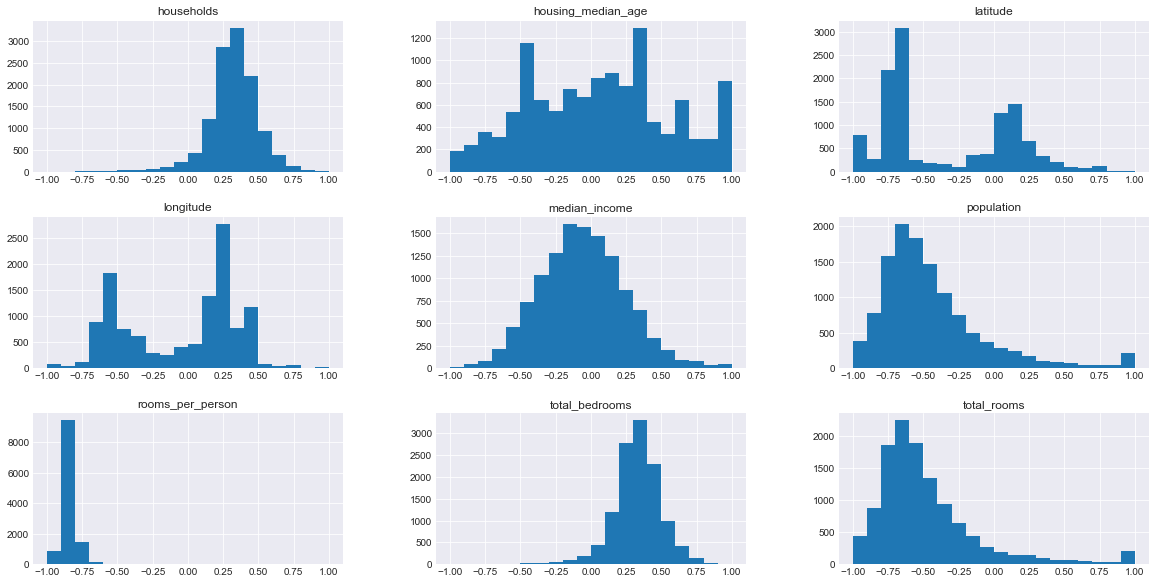

In [136]:
_ = training_normalized.hist(bins = 20, figsize = (20, 10))

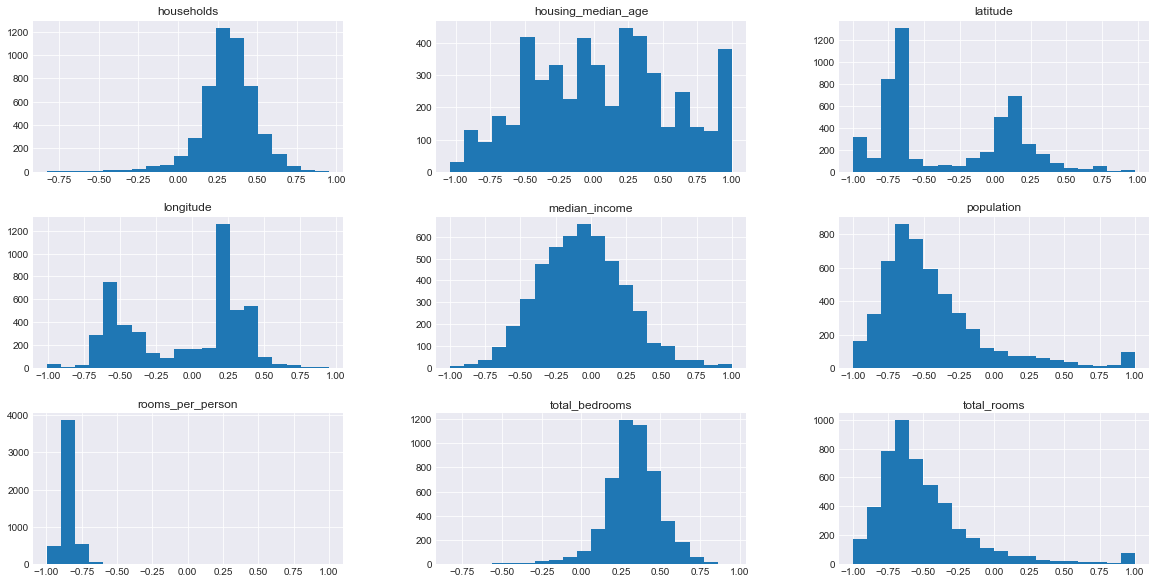

In [137]:
_ = validation_normalized.hist(bins = 20, figsize = (20, 10))

In [ ]:
dnn_regressor = train_model(tf.train.GradientDescentOptimizer(learning_rate = 0.01)
                            2000, 100, [10, 10],
                    training_examples, training_targets, 
                    validation_examples, validation_targets)

Try another run, the results may be different

In [ ]:
dnn_regressor_2 = train_model(0.003, 2000, 100, [10, 10],
                    training_examples, training_targets, 
                    validation_examples, validation_targets)

In [ ]:
# Evaluate that on test set
test_set = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")
test_examples, test_targets = preprocess(test_set)
predicts = dnn_regressor_2.predict(input_fn = lambda: my_input_fn(test_examples, batch_size = 1, num_epochs = 1, shuffle = False))
predicts = np.array([item['predictions'][0] for item in predicts])
rmse = math.sqrt(metrics.mean_squared_error(predicts, test_targets))
print('The final RMSE is: %.2f' %rmse)

In [ ]:
plt.scatter(predicts, test_targets['median_house_value'])
plt.xlabel('predictions')
plt.ylabel('targets')